In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Driven Cavity

In this example we solve the two-dimensional incompressible steady Navier Stokes equations in the Driven Cavity problem

$$
\mathbf{u} \cdot \nabla \mathbf{u} = \frac{1}{Re} \nabla^2 \mathbf{u} - \nabla p
$$

where $\mathbf{u} = (u, v)$ is the velocity of the fluid and $Re$ is the Reynolds number. The geometry of the problem is described as follows

![](https://www.cfd-online.com/W/images/a/a3/Ldc_geom.png)

In [2]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.05', '1.10.0')

In [3]:
U = 1.
Re = 100

class NavierStokes2d(PDE):
    def computePDELoss(self, inputs, outputs):
        
        u, v, p = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        
        # first order derivatives        
        grads = self.computeGrads(u, inputs)       
        dudx, dudy = grads[:, 0], grads[:, 1]
        
        grads = self.computeGrads(v, inputs)       
        dvdx, dvdy = grads[:, 0], grads[:, 1]
        
        grads = self.computeGrads(p, inputs)       
        dpdx, dpdy = grads[:, 0], grads[:, 1]
            
        # second order derivatives        
        du2dx2 = self.computeGrads(dudx, inputs)[:, 0]       
        du2dy2 = self.computeGrads(dudy, inputs)[:, 1]       
        dv2dx2 = self.computeGrads(dvdx, inputs)[:, 0]       
        dv2dy2 = self.computeGrads(dvdy, inputs)[:, 1]       

        
        # compute losses
        return {
            'mass': dudx + dvdy,
            'mom_x': u*dudx + v*dudy + dpdx - (1./Re)*(du2dx2 + du2dy2),
            'mom_y': u*dvdx + v*dvdy + dpdy - (1./Re)*(dv2dx2 + dv2dy2)
        }

# instanciate pde
pde = NavierStokes2d(inputs=('x', 'y'), outputs=('u', 'v', 'p'))

In [4]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [0., 1.], 
    'y': [0., 1.],
}, device=device, n_samples=1000)

pde.set_sampler(sampler)

In [5]:
# left-right walls
from nangs import Dirichlet, Neumann

class NeumannX(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dpdx = self.computeGrads(outputs[:, 2], inputs)[:, 0]
        return {'gradX': dpdx}

In [6]:
n_samples = 1000

left = Dirichlet(
    RandomSampler({'x': [0., 1.], 'y': 0.}, device=device, n_samples=n_samples), 
    lambda inputs: {
        'u' : torch.zeros(n_samples, device=inputs['x'].device),
        'v' : torch.zeros(n_samples, device=inputs['x'].device),
    },
    name="left"
)

pde.add_boco(left)

left_p = NeumannX(
    RandomSampler({'x': [0., 1.], 'y': 0.}, device=device, n_samples=n_samples), 
    name='left-p'
)

pde.add_boco(left_p)

Boco left with different outputs ! ('u', 'v', 'p') vs ('u', 'v')


In [7]:
right = Dirichlet(
    RandomSampler({'x': [0., 1.], 'y': 1.}, device=device, n_samples=n_samples), 
    lambda inputs: {
        'u' : torch.zeros(n_samples, device=inputs['x'].device),
        'v' : torch.zeros(n_samples, device=inputs['x'].device),
    },
    name="right"
)

pde.add_boco(right)

right_p = NeumannX(
    RandomSampler({'x': [0., 1.], 'y': 1.}, device=device, n_samples=n_samples), 
    name='right-p'
)

pde.add_boco(right_p)

Boco right with different outputs ! ('u', 'v', 'p') vs ('u', 'v')


In [8]:
# bootom wall

class NeumannY(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dpdy = self.computeGrads(outputs[:, 2], inputs)[:, 1]
        return {'gradY': dpdy}

In [9]:
bot = Dirichlet(
    RandomSampler({'x': 0., 'y': [0., 1.]}, device=device, n_samples=n_samples), 
    lambda inputs: {
        'u' : torch.zeros(n_samples, device=inputs['x'].device),
        'v' : torch.zeros(n_samples, device=inputs['x'].device),
    },
    name="bot"
)

pde.add_boco(bot)

bot_p = NeumannY(
    RandomSampler({'x': 0., 'y': [0., 1.]}, device=device, n_samples=n_samples), 
    name='bot-p'
)

pde.add_boco(bot_p)

Boco bot with different outputs ! ('u', 'v', 'p') vs ('u', 'v')


In [10]:
top = Dirichlet(
    RandomSampler({'x': 1., 'y': [0., 1.]}, device=device, n_samples=n_samples), 
    lambda inputs: {
        'u' : torch.ones(n_samples, device=inputs['x'].device)*U,
        'v' : torch.zeros(n_samples, device=inputs['x'].device),
    },
    name="top"
)

pde.add_boco(top)

top_p = NeumannY(
    RandomSampler({'x': 1., 'y': [0., 1.]}, device=device, n_samples=n_samples), 
    name='top-p'
)

pde.add_boco(top_p)

Boco top with different outputs ! ('u', 'v', 'p') vs ('u', 'v')


In [11]:
# solve

from nangs import MLP

LR = 1e-3
N_STEPS = 5000
NUM_LAYERS = 3
NUM_HIDDEN = 100

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'mass': 0.00015, 'mom_x': 0.00038, 'mom_y': 5e-05, 'left': 0.00195, 'left-p_gradX': 5e-05, 'right': 0.0016, 'right-p_gradX': 8e-05, 'bot': 0.08011, 'bot-p_gradY': 2e-05, 'top': 0.09178, 'top-p_gradY': 2e-05}: 100%|██████████| 5000/5000 [01:23<00:00, 59.61it/s]

CPU times: user 1min 23s, sys: 799 ms, total: 1min 24s
Wall time: 1min 23s


In [ ]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [12]:
# evaluate the solution

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)

grid = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
X = torch.from_numpy(grid).float().to(device)
outputs = pde.eval(X).cpu()

u = outputs[:, 0].view(len(x),len(y)).numpy()
v = outputs[:, 1].view(len(x),len(y)).numpy()
p = outputs[:, 2].view(len(x),len(y)).numpy()

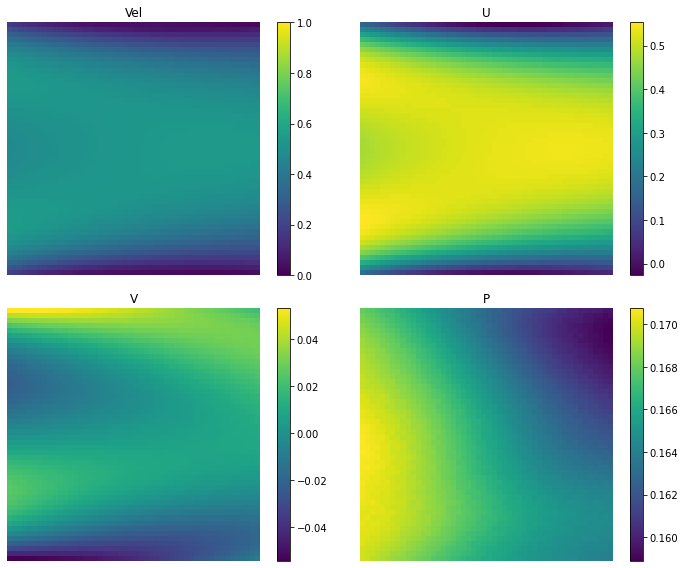

In [13]:
# plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
vel = np.sqrt(u**2 + v**2)
im=ax1.imshow(vel, vmin=0, vmax=1, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax1)
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax1.set_title("Vel")
ax1.axis(False)
im=ax2.imshow(u, vmin=u.min(), vmax=u.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax2)
ax2.set_title("U")
im=ax3.imshow(v, vmin=v.min(), vmax=v.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax3)
ax2.axis(False)
ax3.axis(False)
ax3.set_title("V")
im=ax4.imshow(p, vmin=p.min(), vmax=p.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax4)
ax4.axis(False)
ax4.set_title("P")
plt.tight_layout()
plt.show()

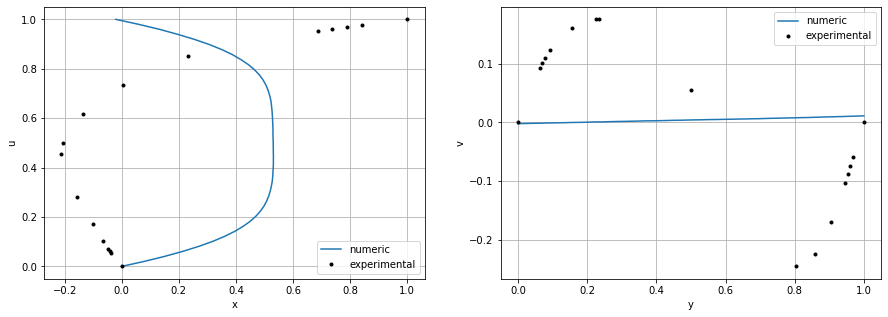

In [14]:
# profiles

mid_u = u[:,len(u)//2]
mid_v = v[len(v)//2,:]
exp_u = pd.read_csv('data/dc_100_ux.csv', header=None).values
exp_v= pd.read_csv('data/dc_100_uy.csv', header=None).values

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1.plot(mid_u, y, label="numeric")
ax1.plot(exp_u[:,0], exp_u[:,1], '.k', label="experimental")
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.legend()
ax1.grid(True)
ax2 = plt.subplot(122)
ax2.plot(x,mid_v, label="numeric")
ax2.plot(exp_v[:,0], exp_v[:,1], '.k', label="experimental")
ax2.legend()
ax2.set_xlabel('y')
ax2.set_ylabel('v')
ax2.grid(True)
plt.show()